In [92]:
pip install PyWavelets

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
import numpy as np
import pandas as pd
import os
import shutil
import matplotlib.pyplot as plt
import librosa.display
from sklearn.preprocessing import StandardScaler
import pywt
import IPython

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [94]:
audio, sr = librosa.load("./Audios/Benjamin_Netanyau/0.wav")

In [95]:
recortado_path = './Audios/Julia_Gillard/1.wav'
IPython.display.Audio(recortado_path)


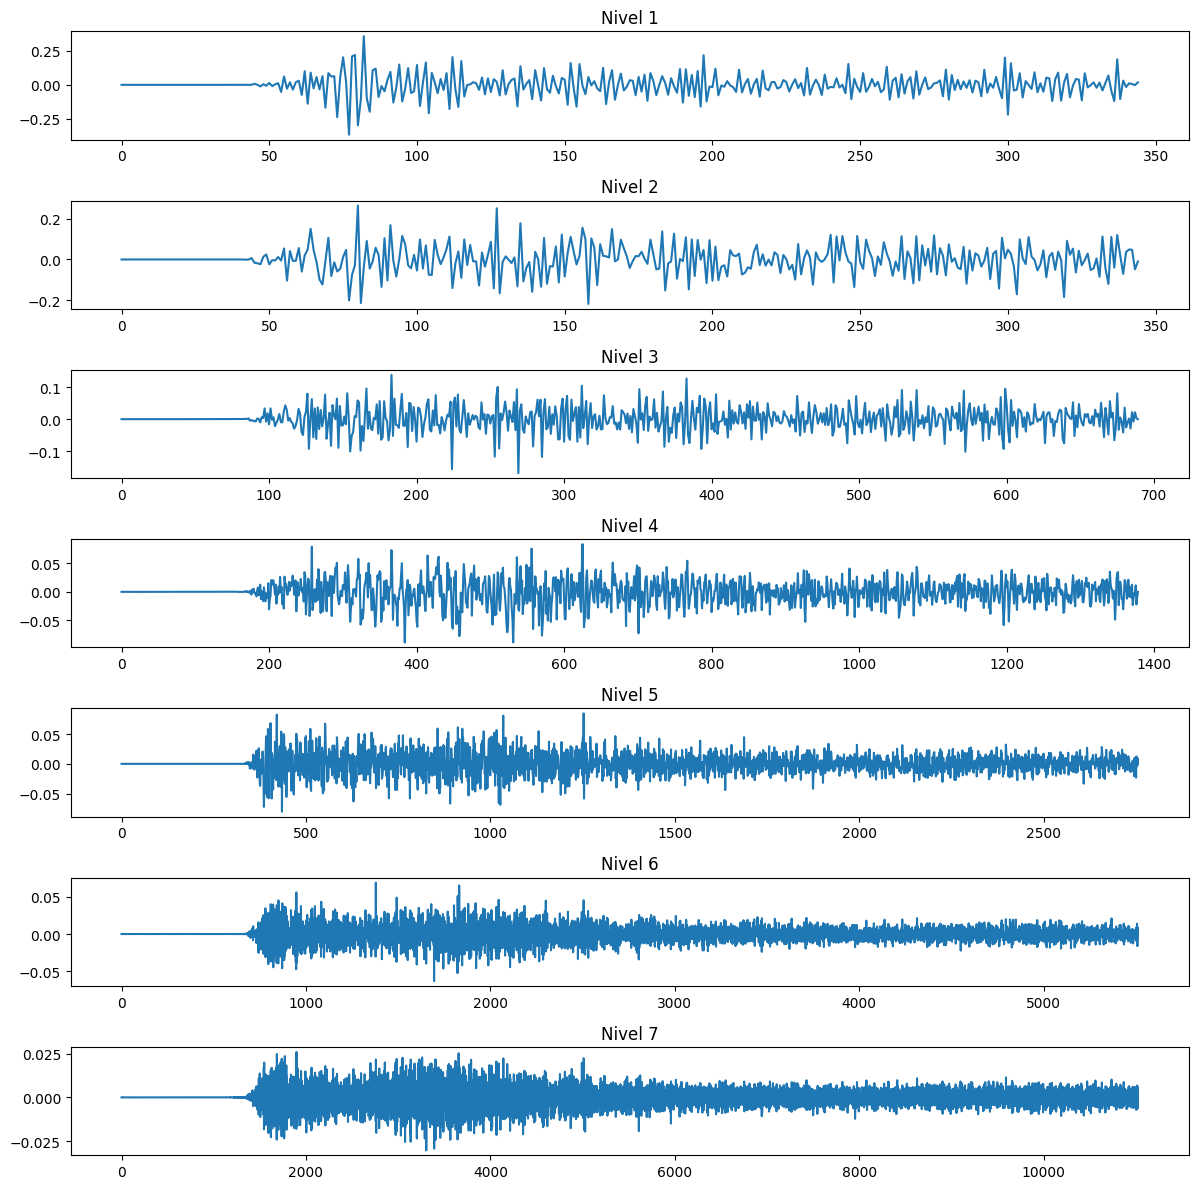

In [96]:
coeffs = pywt.wavedec(audio, 'db1', level=6)
# Visualización de la descomposición
fig, axs = plt.subplots(len(coeffs), 1, figsize=(12, 12))
for i, coeff in enumerate(coeffs):
    axs[i].plot(coeff)
    axs[i].set_title(f'Nivel {i+1}')
plt.tight_layout()
plt.show()

In [97]:
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

In [98]:
# Normalize MFCC features
mfccs = StandardScaler().fit_transform(mfccs)

In [99]:
mfccs.shape

(13, 44)

In [100]:
coeffs_list = []

In [101]:
coeffs = pywt.wavedec(audio, 'db1', level=10)
coeffs_flattened = np.concatenate(coeffs)
coeffs_list.append(coeffs_flattened)

In [102]:
len(np.array(coeffs_list)[0])

22057

In [103]:
# Output directory to clear
ruta = "./Audios"

speaker_folders = [
    "Benjamin_Netanyau",
    "Jens_Stoltenberg",
    "Julia_Gillard",
    "Magaret_Tarcher",
    "Nelson_Mandela"
]

speaker_folders2 = [
    "Prueba"
]

In [106]:
def extract_features(parent_dir, speaker_folders):
    features = []
    labels = []

    for i, speaker_folder in enumerate(speaker_folders):
        speaker_folder_path = os.path.join(parent_dir, speaker_folder)

        for filename in os.listdir(speaker_folder_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(speaker_folder_path, filename)
                audio, sr = librosa.load(file_path, sr=None, duration=1)
                coeffs = pywt.wavedec(audio, 'db1', level=10)
                # Encontrar la longitud máxima de los coeficientes
                max_length = max(len(coeff) for coeff in coeffs)

                feature = []

                # Rellenar los coeficientes para que tengan la misma longitud
                for coeff in coeffs:
                    padded_coeff = np.pad(coeff, (0, max_length - len(coeff)), 'constant')
                    feature.append(padded_coeff)
                
                features.append(np.array(feature).T)
                labels.append(i)

    return np.array(features), np.array(labels)

In [107]:
X, y = extract_features(ruta, speaker_folders)

In [108]:
for feature in X[:1]:
    print(feature)

[[-4.9877155e-04 -4.7684007e-06 -1.8881779e-05 ...  1.0789592e-05
   1.5258788e-05  0.0000000e+00]
 [-6.7424757e-04  2.0694727e-04 -9.4408751e-06 ... -2.1579186e-05
   0.0000000e+00 -2.1579186e-05]
 [-5.9623774e-03 -3.8013374e-03 -1.2138291e-05 ... -1.0789592e-05
  -1.5258788e-05 -2.1579186e-05]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  2.5031855e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.1074029e-03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  2.1579210e-05]]


In [109]:
import tensorflow as tf

In [111]:
from sklearn.preprocessing import LabelEncoder
# Encode labels with explicit classes
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_encoder.classes_ = np.array(speaker_folders)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of training and validation data
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (5250, 8000, 11)
Validation Data Shape: (1125, 8000, 11)


In [112]:
# Define the RNN model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(speaker_folders), activation='softmax')
])

c:\Users\Claudia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [113]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [114]:
from tensorflow.keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

In [115]:
# Train the model with EarlyStopping
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 980s 6s/step - accuracy: 0.2024 - loss: 1.6098 - val_accuracy: 0.1982 - val_loss: 1.6085
Epoch 2/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 932s 6s/step - accuracy: 0.2176 - loss: 1.6135 - val_accuracy: 0.1920 - val_loss: 1.6091
Epoch 3/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 870s 5s/step - accuracy: 0.2273 - loss: 1.6049 - val_accuracy: 0.2560 - val_loss: 1.6025
Epoch 4/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 849s 5s/step - accuracy: 0.2331 - loss: 1.5997 - val_accuracy: 0.2489 - val_loss: 1.5933
Epoch 5/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 860s 5s/step - accuracy: 0.2641 - loss: 1.5887 - val_accuracy: 0.3200 - val_loss: 1.5569
Epoch 6/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 838s 5s/step - accuracy: 0.3234 - loss: 1.5402 - val_accuracy: 0.3298 - val_loss: 1.4650
Epoch 7/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 835s 5s/step - accuracy: 0.3220 - loss: 1.4762 - val_accuracy: 0.3316 - val_loss: 1.4491
Epoch 8/20
165/165 ━━━━━━━━━━━━━━━━━━━━ 837s 5s/step - accuracy: 0.3295 - loss: 1.4478 - val_accu

In [116]:
# Check if EarlyStopping triggered
if early_stopping.stopped_epoch > 0:
    print("Early stopping triggered at epoch", early_stopping.stopped_epoch + 1)
else:
    print("Training completed without early stopping")

Early stopping triggered at epoch 11


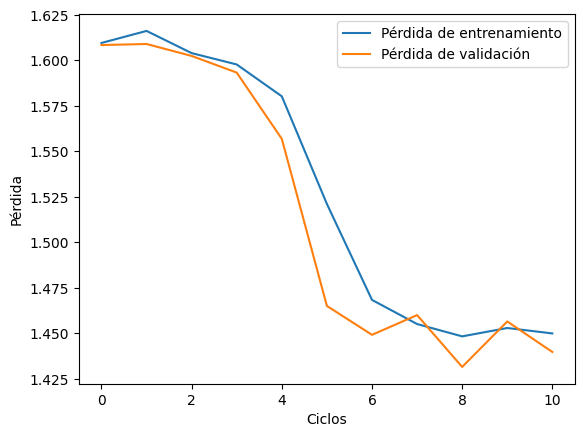

In [117]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Ciclos')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

36/36 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step
Test Evaluation Accuracy: 0.3241563055062167
Weighted F1 Score: 0.3005292348126475


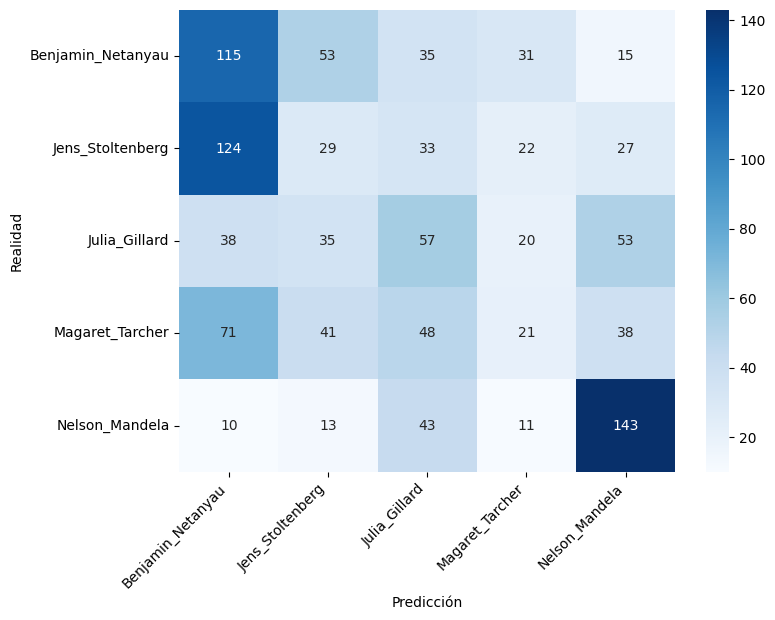

In [118]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

# Evaluate the model on the test set
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Decode labels back to original format
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded, labels=speaker_folders)

# Calculate accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f"Test Evaluation Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test_decoded, y_pred_decoded, labels=speaker_folders, average='weighted')
print(f"Weighted F1 Score: {f1}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=speaker_folders, yticklabels=speaker_folders)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha="right")

plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()